In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # or "0,1"

In [ ]:
wandb.init(project="tesi", name="bigbird")  # args = TrainingArguments(
wandb.stop()

In [1]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained(
    './robertaLargeNil/checkpoint-2772'
)
model = AutoModelForQuestionAnswering.from_pretrained('./robertaLargeNil/checkpoint-2772', return_dict=False
).to('cuda:0')

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import json
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenized = []
file_path = "./train4.jsonl"
from datasets import Dataset

original_data = []
with open(file_path, "r") as file:
    for line in file:
        # Load each line as a JSON object
        data_line = json.loads(line)
        
        
        original_data.append(data_line)
print(len(original_data))

7939


In [3]:
import json
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenized = []
file_path = "./aida_train_converted.jsonl"
from datasets import Dataset

original_data_aida = []
with open(file_path, "r") as file:
    for line in file:
        # Load each line as a JSON object
        data_line = json.loads(line)
        for item in data_line:
        # additional_question = "<additional> "
        # try:
        #     for related in data_line["most_related"]:
        #         length = len(related)
        #         if len(related) == 4:
        #             additional_question += related[2]
        #             additional_question += " "
        # except:
        #     None
        # additional_question += "</additional>"
        # data_line["context"] += additional_question
            original_data_aida.append(item)
print(len(original_data_aida))

18448


In [4]:
import random
concat = original_data_aida
dataset =original_data_aida[:int(len(original_data_aida)* 0.7)] + original_data


## Prediction and evaluation

In [5]:
def check_brackets(input_string):
    stack = []
    brackets = {"(": ")", "{": "}", "[": "]"}
    for char in input_string:
        if char in brackets.keys():
            stack.append(char)
        elif char in brackets.values():
            if not stack or brackets[stack.pop()] != char:
                return False
    return not stack


def process_answer(answer, candidates):
    if answer == "Not In Candidates":
        return answer
    else:
        modified_answer = answer.split("</ec>")[0]
        modified_answer = modified_answer.split(": instance of ")[0]
        modified_answer = modified_answer.split(": instance")[0]
        modified_answer = modified_answer.replace("<s>","")
        modified_answer = modified_answer.replace("</ec","")
        modified_answer = modified_answer.replace("</s>","")
        modified_answer = modified_answer.replace("<s", "")
        modified_answer = modified_answer.replace("</", "")
        modified_answer = modified_answer.replace(" ec", "")
        modified_answer = modified_answer.replace(">","")
        modified_answer = modified_answer.strip()
        if not check_brackets(modified_answer):
            modified_answer = modified_answer.replace("(", "")
            modified_answer = modified_answer.replace(")", "")
        if modified_answer == "Not In Candidates":
            modified_answer = "Not In Candidates"
        if modified_answer == "":
            modified_answer = "Not In Candidates"
        if modified_answer not in candidates:
            modified_answer = "Not In Candidates"
        return modified_answer
process_answer("> Alzenau </", ["Alzenau"])

'Alzenau'

In [6]:
import gc
import torch.nn.functional as F
import numpy as np

def entropy(p):
    return -np.sum(p * np.log2(p))

def make_prediction(data_entry, nil_prediction):
    with torch.no_grad():
        question = data_entry["context"]
        context = data_entry["question"]
        candidates = context.split(' </ec>')
        context = ''
        if nil_prediction:
            index = 0
            added = False
            for item in candidates:
                context += item + f" </ec> "
                index += 1
                if index == 1 and nil_prediction:
                    context += " Not In Candidates </ec> "
                    added = True
            if not added and nil_prediction:
                context = " Not In Candidates </ec> " + context
       
        input_pairs = [question, context]
        encodings = tokenizer.encode_plus(
            input_pairs, return_tensors="pt", truncation="only_second"
        ).to("cuda")
        start_scores, end_scores = model(
            encodings["input_ids"], attention_mask=encodings["attention_mask"]
        )
        start_scores = F.softmax(start_scores, dim=1)
        end_scores = F.softmax(end_scores, dim=1)

        startEntropy = entropy(start_scores[0].cpu().numpy())
        endEntropy = entropy(end_scores[0].cpu().numpy())
        # calculate mean entropy
        meanEntropy = (startEntropy + endEntropy) / 2
        # start_scores.to("cpu")
        # end_scores.to("cpu")
        start = torch.argmax(start_scores) # Get the most likely beginning of answer with the argmax of the score
        end = (torch.argmax(end_scores) + 1) # Get the most likely end of answer with the argmax of the score
        mean_score = 0
        try:
            mean_score = (
                end_scores[0][end.item()] + start_scores[0][start.item()]
            ) 
        except:
            None
        answer_tokens = encodings["input_ids"][0, start.item() : end.item() + 1]
        answer = ""

        answer = process_answer(tokenizer.decode(answer_tokens), context)
        
        del encodings
        del end_scores
        del start_scores
        del start
        del end
        score = float(mean_score)
        gc.collect()
        torch.cuda.empty_cache()
        return {
            "correct": data_entry["answers"],
            "non_processed": tokenizer.decode(answer_tokens),
            "predicted": answer,
            "input_phrase": question,
            "scores": score,
            "candidates": context,
            "entropy": meanEntropy,

        }

In [7]:
from tqdm import tqdm
import json
import torch

results = []

for item in tqdm(dataset):
    try:
        pred = make_prediction(item, True)
        results.append(pred)
    except Exception as e:
        print(e)

100%|██████████| 20852/20852 [56:04<00:00,  6.20it/s] 


In [8]:
correct = 0
correct_trace = []
wrong = []
correct_nil = 0
wrong_nil = 0
full_data = []
for result in tqdm(results):
  processed = result['predicted']
  if processed == result['correct']['text']:
    correct += 1
    correct_trace.append(result)
    if processed == 'Not In Candidates':
        correct_nil += 1
  
  else:
    if result['correct']['text'] == 'Not In Candidates':
        wrong_nil += 1
    wrong.append(result)
  full_data.append(result)

100%|██████████| 20852/20852 [00:00<00:00, 1476485.64it/s]


In [9]:
import pandas as pd
import joblib
full_df = pd.DataFrame(results)
joblib.dump(full_df,'./fullDfAidaGridEntropy.dump')

['./fullDfAidaGridEntropy.dump']

In [1]:
import pandas as pd
import joblib
full_df = joblib.load('./fullDfAidaGrid.dump')


In [6]:
import pandas as pd
full_df = pd.read_csv('./resultsAidaNILELTrainForGridSearch.csv')

In [22]:
print(f"accuracy of the model is {correct/len(results)}")
print(f"accuracy in nil prediction is: {correct_nil/(correct_nil+wrong_nil)}")

accuracy of the model is 0.0


ZeroDivisionError: division by zero

## Grid Search threshold

In [8]:
full_df.head(1)

,Unnamed: 0,correct,non_processed,predicted,input_phrase,scores,candidates
0,0,"{'answer_start': [22], 'text': ['Germany']}",Not In Candidates </ec> Germany </ec,NIL,Eu rejects [START_ENT] German [END_ENT] call t...,0.898397,German language </ec> Not In Candidates </ec>...


In [16]:
import numpy as np
from tqdm import tqdm
parameters = np.linspace(0,1,1000)

In [11]:
parameters[:10]

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909])

In [17]:
from multiprocessing import Pool


def compute_accuracy(param):
    totalItems = len(full_df)
    correct = 0
    correctNIL = 0
    wrongNIL = 0
    for index, item in full_df.iterrows():
        score = item["entropy"]
        answer = item["correct"]["text"][0]
        predicted = item["predicted"]
        if score > param:
            predicted = "Not In Candidates"
        if answer == predicted:
            correct += 1
            if answer == "Not In Candidates":
                correctNIL += 1
        else:
            if answer == "Not In Candidates":
                wrongNIL += 1
    acc = float(correct / totalItems)
    accNIL = correctNIL / (correctNIL + wrongNIL)
    meanAcc = (acc + accNIL) / 2
    return meanAcc


if __name__ == "__main__":
    with Pool() as p:
        accuracies = list(
            tqdm(p.imap(compute_accuracy, parameters), total=len(parameters))
        )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


In [12]:
accuracies = []

for param in tqdm(parameters):
    totalItems = len(full_df)
    correct = 0
    correctNIL = 0
    wrongNIL = 0
    for index, item in full_df.iterrows():
        score = item['entropy']
        answer = item['correct']['text'][0]
        predicted = item['predicted']
        if score > param:
            predicted = 'Not In Candidates'
        if answer == predicted:
            correct += 1
            if answer == 'Not In Candidates':
                correctNIL += 1
        else:
            if answer == 'Not In Candidates':
                wrongNIL += 1
    acc = float(correct/totalItems)
    accNIL = correctNIL / (correctNIL + wrongNIL)
    meanAcc = (acc + accNIL) / 2
    accuracies.append(meanAcc)


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [13]:
accuracies[len(accuracies) -10 :]

[0.866729785814947,
 0.8666861803410196,
 0.8666425748670923,
 0.8664594498582363,
 0.8659689557076994,
 0.8659733072642728,
 0.8661411568710251,
 0.8662850279625272,
 0.8664768560845297,
 0.8666686842065325]

In [19]:
maxAcc = max(accuracies)
maxIndex = accuracies.index(maxAcc)

print(f'The max accuracy is {maxAcc} with a threshold of {parameters[maxIndex]}')

The max accuracy is 0.870599479424366 with a threshold of 0.5785785785785785


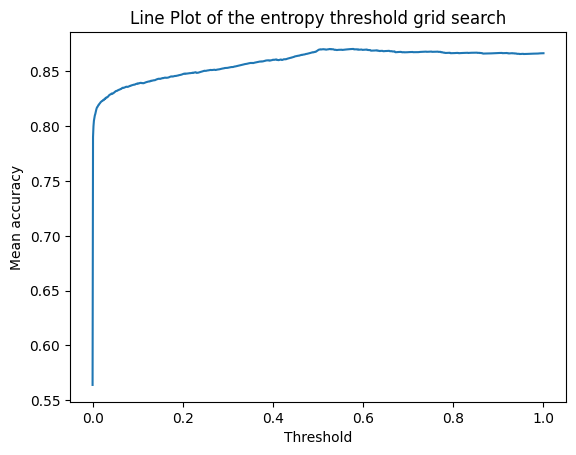

In [20]:
import matplotlib.pyplot as plt

# Sample data
x = parameters
y = accuracies
plt.plot(x, y)

plt.xlabel('Threshold')
plt.ylabel('Mean accuracy')
plt.title('Line Plot of the entropy threshold grid search')

plt.show()